<a href="https://colab.research.google.com/github/ilyandho/FPL-Optimal-Transfer/blob/main/Tuned_models.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


## Fetch and extract important attributes from FPL API

Store the data to _`player_data.csv`_


In [2]:
from sklearn.compose import TransformedTargetRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler

In [3]:
import requests
import json
import pandas as pd


base_url = 'https://fantasy.premierleague.com/api/'


# This functionn fetches the player details using FPL API up to a given week


def get_player_data(gw):

    # Get the general, inorder to have access to the team ids in the elements component

    general_info = requests.get(base_url + "/bootstrap-static/").json()

    # player_history will contain the data

    player_history = []

    # For each game week, the stats for all players

    for gwk in range(1, gw+1):

        r = requests.get(base_url + 'event/' + str(gwk) + '/live/').json()

        # Get the fixtures for each game week gwk.

        # It will contain 10 matches with each match containing the stats for the home and away team difficulty rating.

        fixture = requests.get(base_url + 'fixtures?event=' + str(gwk)).json()

        # For each player we will also need the match difficulty for both player's team and plyaer's opponent team.

        for player in r['elements']:

            team_h_difficulty = 0

            team_a_difficulty = 0

            # Get the player element id in the player component and compare it to the id of the element in elements component of general_info

            # Also get the player position which will later be used to filter the data by position

            player_team = None

            position = None

            for element in general_info['elements']:

                if player['id'] == element['id']:

                    player_team = element['team']

                    position = element['element_type']

            # For each match in the fixture array, we compare the player team id with the away team and home team ids in the match.

            # If they match either, then update team_h_difficulty and team_a_difficulty

            for match_ in fixture:

                if player_team == match_['team_a'] or player_team == match_['team_h']:

                    team_h_difficulty = match_['team_h_difficulty']

                    team_a_difficulty = match_['team_a_difficulty']

            # Create a temporary variable containing the gwk, team_a_difficulty, team_h_difficulty and position

            temp_data = {'id': int(player['id']), 'gw': gwk, 'team_h_difficulty': team_h_difficulty,
                         'team_a_difficulty': team_a_difficulty, 'position': position}

            # The stats element in each player component contains:

            #  - minutes, goals_scored, assists, clean_sheets, goals_conceded, own_goals, penalties_saved,

            #  - penalties_missed, yellow_cards, red_cards, saves, bonus, bps, influence,

            #  - creativity, threat, ict_index, starts, expected_goals, expected_assists,

            #  - expected_goal_involvements, expected_goals_conceded, total_points, in_dreamteam

            for key in player['stats'].keys():

                temp_data.update({key: player['stats'][key]})

            # Append the player info to the player_history array

            player_history.append(temp_data)
    return player_history


# Separate the week to be predicted
##
def get_details(gw):
    player_data = pd.DataFrame(get_player_data(gw))

    # Separate next gw's data
    next_gw_data = player_data[player_data['gw'] == gw]

    # Drop this data from the rest of data
    player_data = player_data.drop(player_data[player_data['gw'] == gw].index)

    return player_data, next_gw_data


details = get_details(36)

In [6]:
player_data = details[0]
next_gw_data = details[1]
# Of the features, we want to use features that are available at the time the model is running.
# This makes sure that the model only depends on games stats that are available before the match starts.
# These will store in the 'attributes' variable and we will subsquently be using these for the rest of the work.
attributes = ['id', 'team_h_difficulty', 'team_a_difficulty', 'position',
              'threat', 'ict_index', 'expected_goals', 'expected_assists',
              'expected_goal_involvements', 'expected_goals_conceded', 'total_points']
players_data = player_data[attributes]


# Of the features, we want to use features that are available at the time the model is running.
# This makes sure that the model only depends on games stats that are available before the match starts.
# These will store in the 'attributes' variable and we will subsquently be using these for the rest of the work.
attributes = ['id', 'team_h_difficulty', 'team_a_difficulty', 'position',
              'threat', 'ict_index', 'expected_goals', 'expected_assists',
              'expected_goal_involvements', 'expected_goals_conceded', 'total_points']
players_data_next = next_gw_data[attributes]

In [7]:
# Group the players by position
# Here we will train models for each position i.e each position will have its own model for predicting the data
goalkeepers = players_data.loc[players_data['position'] == 1]
defenders = players_data.loc[players_data['position'] == 2]
midfielders = players_data.loc[players_data['position'] == 3]
forwards = players_data.loc[players_data['position'] == 4]

## Get Feature Importances


In [50]:
# Get the feature importance and plots
def get_feature_importances(position_data):
    target = position_data['total_points']
    features = position_data.drop("total_points", axis=1)

    id_ = features['id']
    features = features.drop("id", axis=1)
    [i for i in features.columns]

    forest = RandomForestRegressor(random_state=18)
    forest.fit(features, target)
    feature_names =[i for i in features.columns]

    importances = forest.feature_importances_
    std = np.std([tree.feature_importances_ for tree in forest.estimators_], axis=0)
    forest_importances = pd.Series(importances, index=feature_names)

    fig, ax = plt.subplots()
    forest_importances.plot.bar(yerr=std, ax=ax)
    ax.set_title("Feature importances using MDI")
    ax.set_ylabel("Mean decrease in impurity")
    fig.tight_layout()

### Goalkeepers


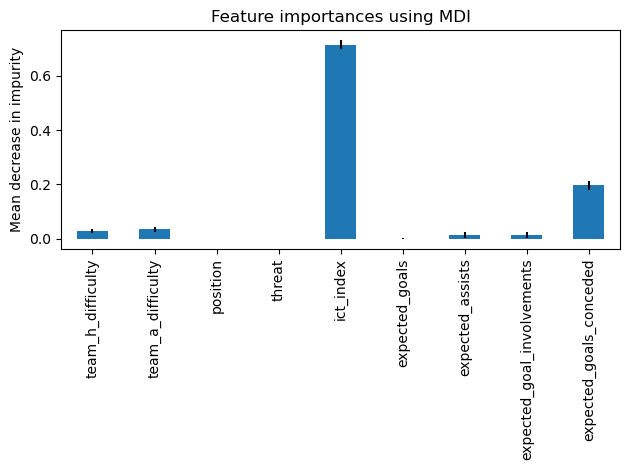

In [51]:
get_feature_importances(goalkeepers)


For goalkeepers, position, threat, and expected_goals play no role in the model performance


### Defenders


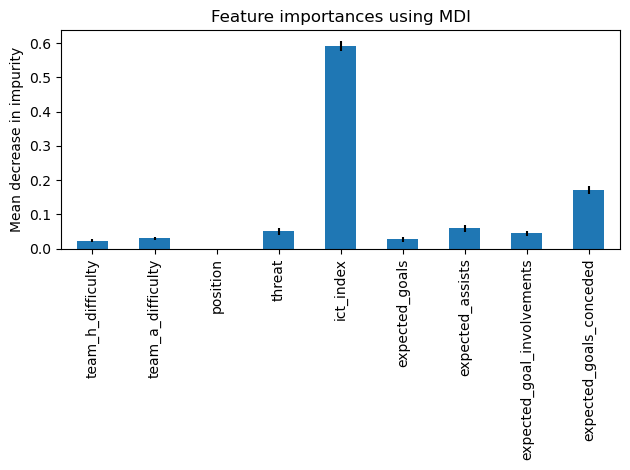

In [53]:
get_feature_importances(defenders)

### Midfielders


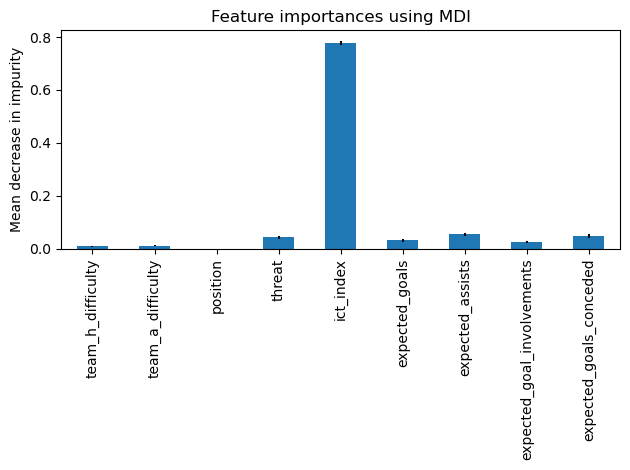

In [52]:
get_feature_importances(midfielders)

For midfielders the position feature plays no role in the model performance


### Forwards


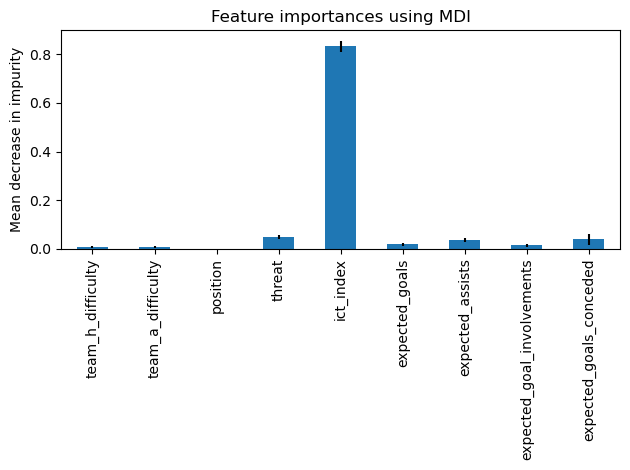

In [54]:
get_feature_importances(forwards)

### Predictor Helper functions


In [84]:
from sklearn.inspection import permutation_importance
import matplotlib.pyplot as plt
import numpy as np

def gk_predictor(data, next_data):
    # Extract the goalkeeper details
    gk_target = data['total_points']
    gk_features = data.drop("total_points", axis=1)

    gk_id = gk_features['id']
    gk_features = gk_features.drop("id", axis=1)

    # Model bBefore feature selection
    gk_rf_model = TransformedTargetRegressor(RandomForestRegressor(
        n_estimators=20,  max_depth=8, criterion='friedman_mse', max_features='sqrt', random_state=18), transformer=StandardScaler())
    gk_rf_model.fit(gk_features.values, gk_target)


    ## Model after feature selection
    feat_gk_features = gk_features.drop(["position", "threat", "expected_goals"], axis=1)
    feat_gk_rf_model = TransformedTargetRegressor(RandomForestRegressor(
        n_estimators=20,  max_depth=8, criterion='friedman_mse', max_features='sqrt', random_state=18), transformer=StandardScaler())
    feat_gk_rf_model.fit(feat_gk_features.values, gk_target)

    print('goalkeeper before feature slection:', gk_rf_model.score(gk_features.values, gk_target))
    print('goalkeeper after feature slection:', feat_gk_rf_model.score(feat_gk_features.values, gk_target))

    # Predictions
    gk_target_next = next_data['total_points']
    gk_features_next = next_data.drop('total_points', axis=1)

    predictions = []
    # gk_id = next_data['id']
    # gk_features_next_ = next_data.drop('id', axis=1)
    # pred = gk_rf_model.predict(gk_features_next_.iloc[69,:].values.reshape(1,-1))

    for i in range(0, len(gk_features_next)):
        # Get the player id
        gk_id = gk_features_next.iloc[i, :]['id']
        gk_features_next_ = gk_features_next.iloc[i, :].drop('id')

        pred = gk_rf_model.predict(gk_features_next_.values.reshape(1, -1))

        predictions.append(
            {'id': gk_id,  "position": 'gk', "total_points": gk_target_next.iloc[i],  "predicted_points": pred[0]})

    return predictions


def def_predictor(data, next_data):
    # Extract the goalkeeper details

    def_target = data['total_points']
    def_features = data.drop("total_points", axis=1)

    def_id = def_features['id']
    def_features = def_features.drop("id", axis=1)

    # Model bBefore feature selection
    def_rf_model = TransformedTargetRegressor(RandomForestRegressor(
        n_estimators=300,  max_depth=8, criterion='friedman_mse', max_features='sqrt', random_state=18), transformer=StandardScaler())
    def_rf_model.fit(def_features.values, def_target)

    ## Model after feature selection
    feat_def_features = def_features.drop(["position"], axis=1)
    feat_def_rf_model = TransformedTargetRegressor(RandomForestRegressor(
        n_estimators=300,  max_depth=8, criterion='friedman_mse', max_features='sqrt', random_state=18), transformer=StandardScaler())
    feat_def_rf_model.fit(feat_def_features.values, def_target)

    print('Defender before feature slection:', def_rf_model.score(def_features.values, def_target))
    print('Defender after feature slection:', feat_def_rf_model.score(feat_def_features.values, def_target))


    # Predictions
    def_target_next = next_data['total_points']
    def_features_next = next_data.drop('total_points', axis=1)

    predictions = []
    # def_id = next_data['id']
    # gk_features_next_ = next_data.drop('id', axis=1)
    # pred = def_rf_model.predict(gk_features_next_.iloc[69,:].values.reshape(1,-1))

    for i in range(0, len(def_features_next)):
        # Get the player id
        def_id = def_features_next.iloc[i, :]['id']
        def_features_next_ = def_features_next.iloc[i, :].drop('id')

        pred = def_rf_model.predict(def_features_next_.values.reshape(1, -1))

        predictions.append(
            {'id': def_id, "position": 'def', "total_points": def_target_next.iloc[i],  "predicted_points": pred[0]})

    return predictions


def mid_predictor(data, next_data):
    # Extract the midfielder details

    mid_target = data['total_points']
    mid_features = data.drop("total_points", axis=1)

    mid_id = mid_features['id']
    mid_features = mid_features.drop("id", axis=1)

    # Model bBefore feature selection
    mid_rf_model = TransformedTargetRegressor(RandomForestRegressor(
        n_estimators=400,  max_depth=8, criterion='friedman_mse', max_features='sqrt', random_state=18), transformer=StandardScaler())
    mid_rf_model.fit(mid_features.values, mid_target)

    ## Model after feature selection
    feat_mid_features = mid_features.drop(["position"], axis=1)
    feat_mid_rf_model = TransformedTargetRegressor(RandomForestRegressor(
        n_estimators=400,  max_depth=8, criterion='friedman_mse', max_features='sqrt', random_state=18), transformer=StandardScaler())
    feat_mid_rf_model.fit(feat_mid_features.values, mid_target)

    print('Midfielder before feature slection:', mid_rf_model.score(mid_features.values, mid_target))
    print('Midfielder after feature slection:', feat_mid_rf_model.score(feat_mid_features.values, mid_target))

    # Predictions
    mid_target_next = next_data['total_points']
    mid_features_next = next_data.drop('total_points', axis=1)

    predictions = []
    # mid_id = next_data['id']
    # mid_features_next_ = next_data.drop('id', axis=1)
    # pred =mid_rf_model.predict(mid_features_next_.iloc[69,:].values.reshape(1,-1))

    for i in range(0, len(mid_features_next)):
        # Get the player id
        mid_id = mid_features_next.iloc[i, :]['id']
        mid_features_next_ = mid_features_next.iloc[i, :].drop('id')

        pred = mid_rf_model.predict(mid_features_next_.values.reshape(1, -1))

        predictions.append(
            {'id': mid_id, "position": 'mid', "total_points": mid_target_next.iloc[i],  "predicted_points": pred[0]})

    return predictions


def for_predictor(data, next_data):
    # Extract the midfielder details

    for_target = data['total_points']
    for_features = data.drop("total_points", axis=1)

    for_id = for_features['id']
    for_features = for_features.drop("id", axis=1)
    # The Model
    for_lin_model = TransformedTargetRegressor(
        LinearRegression(), transformer=StandardScaler())
    for_lin_model.fit(for_features.values, for_target)

    # Model bBefore feature selection
    for_rf_model = TransformedTargetRegressor(RandomForestRegressor(
        n_estimators=400,  max_depth=8, criterion='friedman_mse', max_features='sqrt', random_state=18), transformer=StandardScaler())
    for_rf_model.fit(for_features.values, for_target)

    ## Model after feature selection
    feat_for_features = for_features.drop(["position"], axis=1)
    feat_for_rf_model = TransformedTargetRegressor(RandomForestRegressor(
        n_estimators=400,  max_depth=8, criterion='friedman_mse', max_features='sqrt', random_state=18), transformer=StandardScaler())
    feat_for_rf_model.fit(feat_for_features.values, for_target)
    feat_for_lin_model = TransformedTargetRegressor(
        LinearRegression(), transformer=StandardScaler())
    feat_for_lin_model.fit(feat_for_features.values, for_target)
    print('Forward before feature slection:', for_rf_model.score(for_features.values, for_target), for_lin_model.score(for_features.values, for_target))
    print('Forward after feature slection:', feat_for_rf_model.score(feat_for_features.values, for_target), feat_for_lin_model.score(feat_for_features.values, for_target))



    # Predictions
    for_target_next = next_data['total_points']
    for_features_next = next_data.drop('total_points', axis=1)

    predictions = []
    # for_id = next_data['id']
    # for_features_next_ = next_data.drop('id', axis=1)
    # pred =for_rf_model.predict(for_features_next_.iloc[69,:].values.reshape(1,-1))

    for i in range(0, len(for_features_next)):
        # Get the player id
        for_id = for_features_next.iloc[i, :]['id']
        for_features_next_ = for_features_next.iloc[i, :].drop('id')

        pred = for_lin_model.predict(for_features_next_.values.reshape(1, -1))

        predictions.append(
            {'id': for_id, "position": 'for', "total_points": for_target_next.iloc[i],  "predicted_points": pred[0]})

    return predictions

### General predictor


In [85]:
def points_predictor(next_data):
    # Extract data by position
    goalkeepers_next = next_data.loc[next_data['position'] == 1]
    defenders_next = next_data.loc[next_data['position'] == 2]
    midfielders_next = next_data.loc[next_data['position'] == 3]
    forwards_next = next_data.loc[next_data['position'] == 4]

    # Predictions DataFrame
    predictions = pd.DataFrame()

    # Goalkeepers predictions
    # Call the predictor helper functions
    gk_pred = gk_predictor(goalkeepers, goalkeepers_next)

    # Append Gk predictions to predictions DataFrame
    predictions = predictions._append(pd.DataFrame(gk_pred), ignore_index=True)

    # Defenders predictions
    # Call the predictor helper functions
    def_pred = def_predictor(defenders, defenders_next)

    # Append def predictions to predictions DataFrame
    predictions = predictions._append(
        pd.DataFrame(def_pred), ignore_index=True)

    # Midfielders predictions
    # Call the predictor helper functions
    mid_pred = mid_predictor(midfielders, midfielders_next)

    # Append mid predictions to predictions DataFrame
    predictions = predictions._append(
        pd.DataFrame(mid_pred), ignore_index=True)

    # Forwards predictions
    # Call the predictor helper functions
    for_pred = for_predictor(forwards, forwards_next)

    # Append mid predictions to predictions DataFrame
    predictions = predictions._append(
        pd.DataFrame(for_pred), ignore_index=True)

    return predictions.sort_values(by=['id'])


predictions = points_predictor(players_data_next)
predictions

goalkeeper before feature slection: 0.7695203830892433
goalkeeper after feature slection: 0.7689560693463665
Defender before feature slection: 0.6778112280673108
Defender after feature slection: 0.6640471974704913
Midfielder before feature slection: 0.8472769521951707
Midfielder after feature slection: 0.8304339162499199
Forward before feature slection: 0.9280790002844341 0.8504317640489673
Forward after feature slection: 0.9156196197917569 0.8504317640489673


,id,position,total_points,predicted_points
746,1,for,0,1.608641e-01
98,2,def,0,1.094867e-02
375,3,mid,0,1.032618e-02
376,4,mid,0,1.032618e-02
99,5,def,7,2.516657e+00
...,...,...,...,...
373,856,def,0,4.448035e-03
744,857,mid,0,7.248033e-03
97,858,gk,0,-2.109424e-15
374,859,def,0,5.354365e-03


#### Plottings


##### Goalkeeprs


c:\Users\Ilyas\anaconda3\envs\FPL\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\Ilyas\anaconda3\envs\FPL\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\Ilyas\anaconda3\envs\FPL\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\Ilyas\anaconda3\envs\FPL\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Conver

<Axes: xlabel='id', ylabel='predicted_points'>

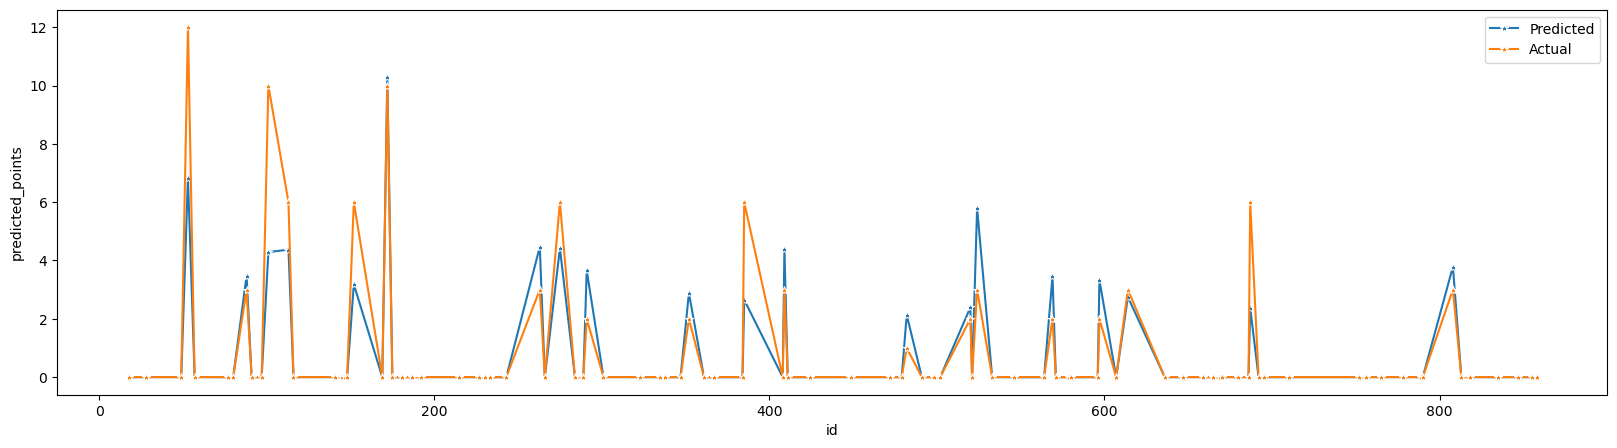

In [29]:
import seaborn as sns
import matplotlib.pyplot as plt

gk_fig, ax = plt.subplots(figsize=(20, 5))
sns.lineplot(data=predictions[predictions['position'] == 'gk'],
             x="id", y='predicted_points', label="Predicted", marker="*")
sns.lineplot(data=predictions[predictions['position'] == 'gk'],
             x="id", y='total_points', label="Actual", marker="*")

##### Defenders


c:\Users\Ilyas\anaconda3\envs\FPL\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\Ilyas\anaconda3\envs\FPL\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\Ilyas\anaconda3\envs\FPL\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\Ilyas\anaconda3\envs\FPL\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Conver

<Axes: xlabel='id', ylabel='predicted_points'>

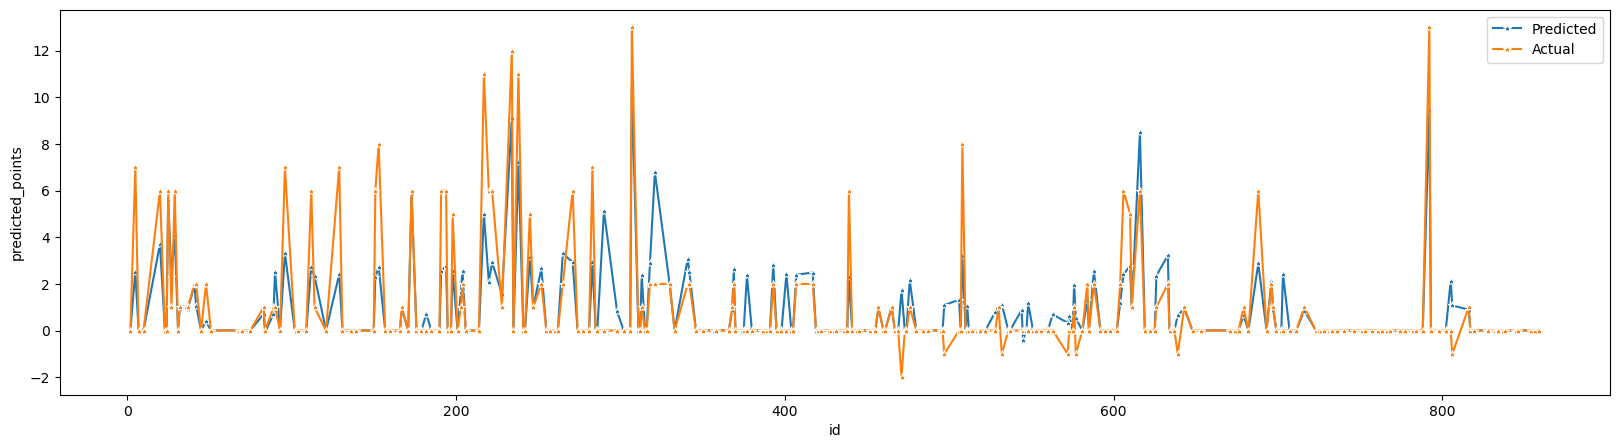

In [30]:

def_fig, ax = plt.subplots(figsize=(20, 5))
sns.lineplot(data=predictions[predictions['position'] == 'def'],
             x="id", y='predicted_points', label="Predicted", marker="*")
sns.lineplot(data=predictions[predictions['position'] == 'def'],
             x="id", y='total_points', label="Actual", marker="*")

##### Midfielders


c:\Users\Ilyas\anaconda3\envs\FPL\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\Ilyas\anaconda3\envs\FPL\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\Ilyas\anaconda3\envs\FPL\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\Ilyas\anaconda3\envs\FPL\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Conver

<Axes: xlabel='id', ylabel='predicted_points'>

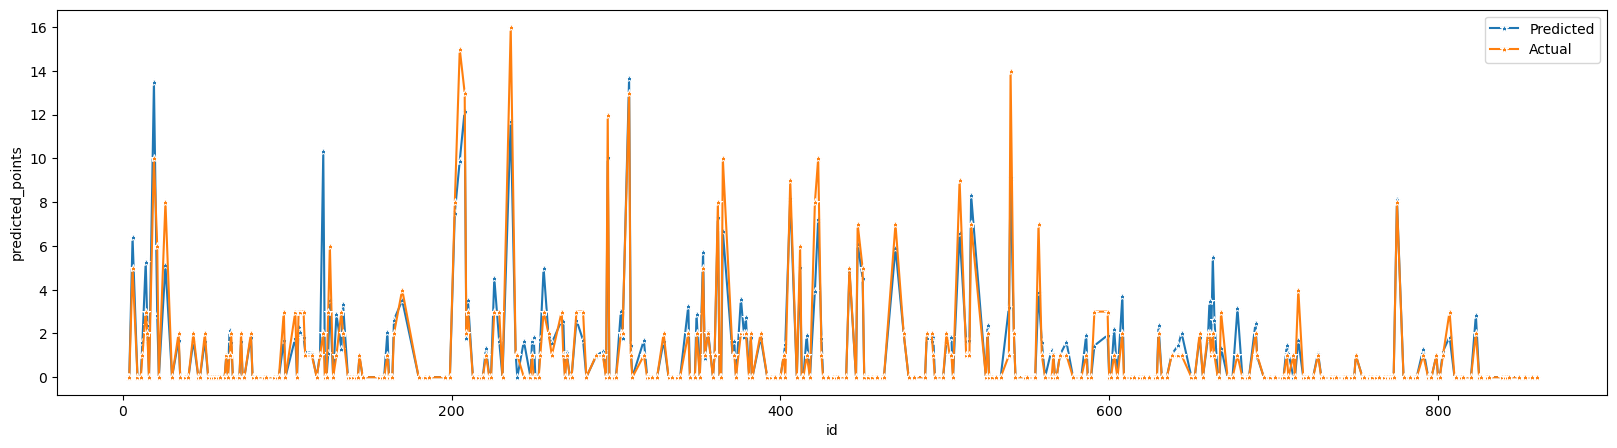

In [31]:

mid_fig, ax = plt.subplots(figsize=(20, 5))
sns.lineplot(data=predictions[predictions['position'] == 'mid'],
             x="id", y='predicted_points', label="Predicted", marker="*")
sns.lineplot(data=predictions[predictions['position'] == 'mid'],
             x="id", y='total_points', label="Actual", marker="*")

##### Forwards


c:\Users\Ilyas\anaconda3\envs\FPL\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\Ilyas\anaconda3\envs\FPL\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\Ilyas\anaconda3\envs\FPL\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\Ilyas\anaconda3\envs\FPL\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Conver

<Axes: xlabel='id', ylabel='predicted_points'>

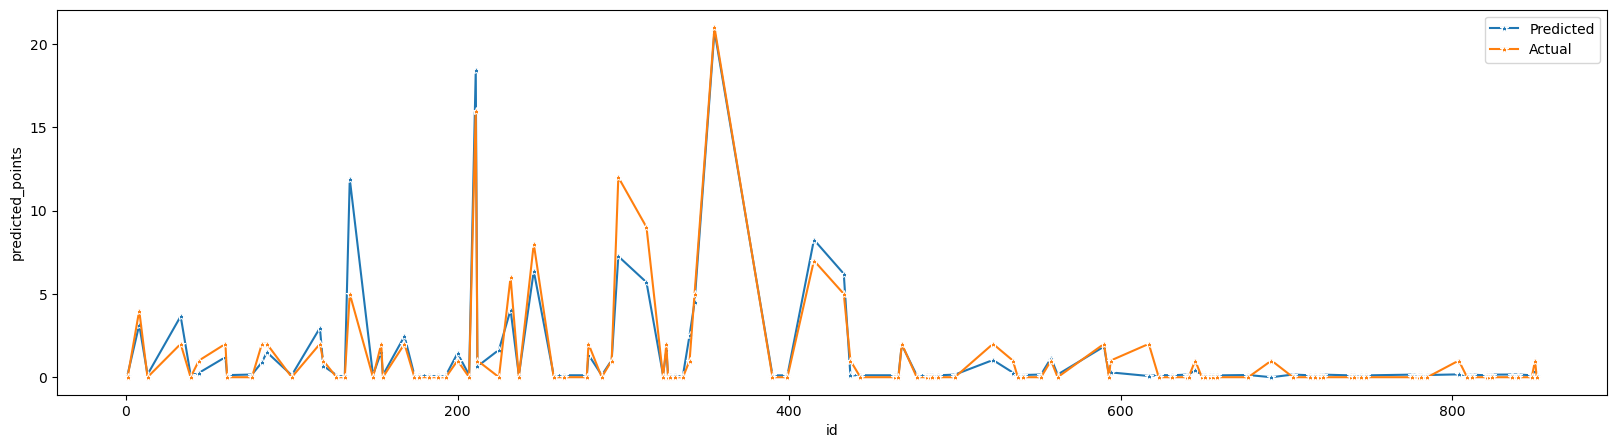

In [32]:

for_fig, ax = plt.subplots(figsize=(20, 5))
sns.lineplot(data=predictions[predictions['position'] == 'for'],
             x="id", y='predicted_points', label="Predicted", marker="*")
sns.lineplot(data=predictions[predictions['position'] == 'for'],
             x="id", y='total_points', label="Actual", marker="*")